In [ ]:
# Let's begin by importing and cleaning the dataset
import pandas as pd

spotify = pd.read_csv("universal_top_spotify_songs.csv")

spotify = spotify.dropna()   # get rid of any rows with missing values
spotify = spotify.drop(columns=["spotify_id", "time_signature", "key","album_release_date", "album_name"])    # the set is massive, so let's get rid of columns we're not interested in to make it slightly faster to work with

spotify['snapshot_date'] = pd.to_datetime(spotify['snapshot_date'])  # convert snapshot_date to datetime
spotify['duration_minutes'] = spotify['duration_ms'] / (60000)   # convert duration from milliseconds to minutes for easier analysis

spotify.head()

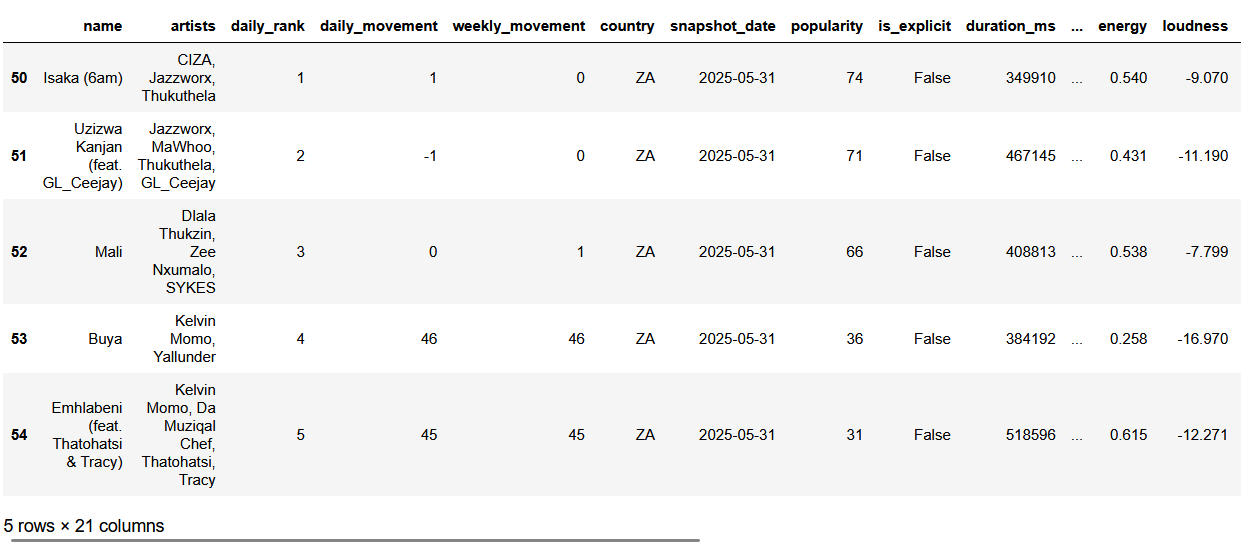

##### Generating a report for EDA and quick analysis

Let's see what we're working with! I love ydata_profiling for quick analysis and EDA because it generates a report with all the information we need in one place

I especially like it because it gives us a quick overview of the dataset, including missing values, data types, and my all time favorite: heatmaps!


In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(spotify, title="Spotify Data Report")
profile.to_notebook_iframe()

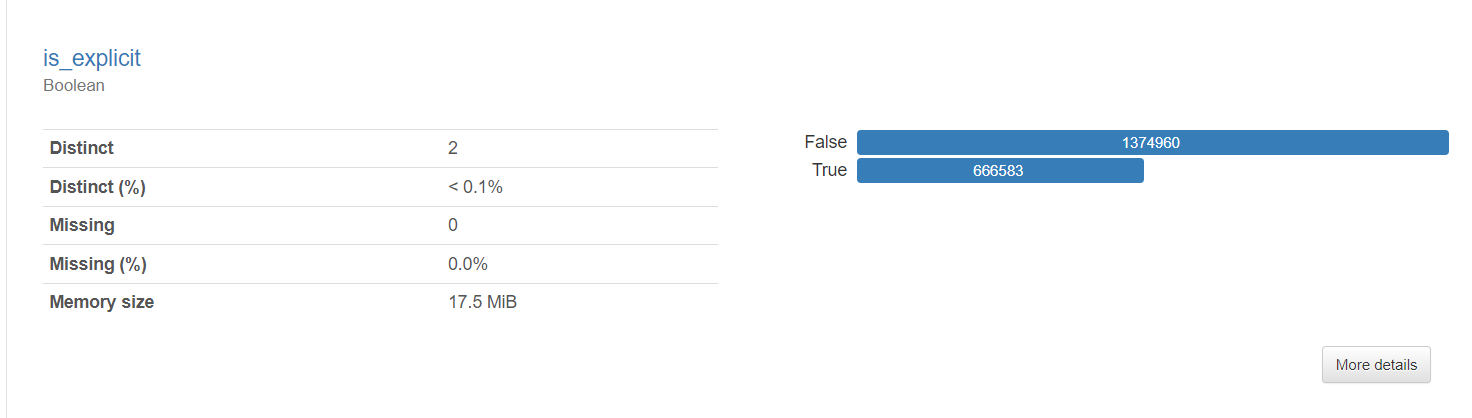

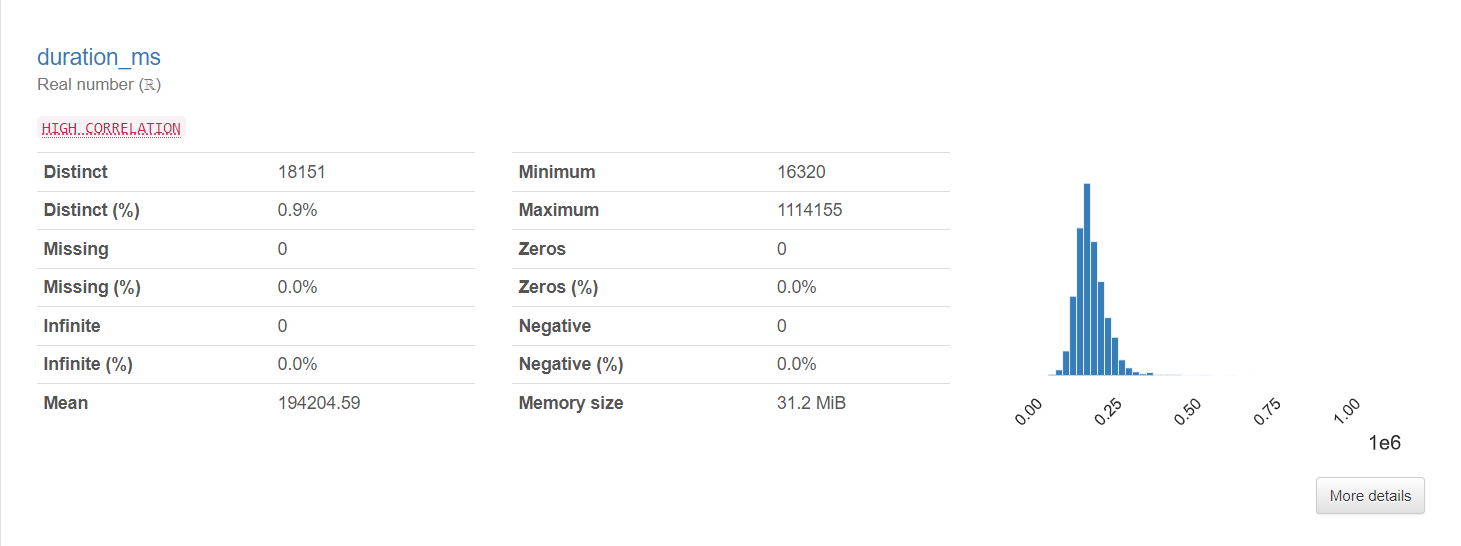

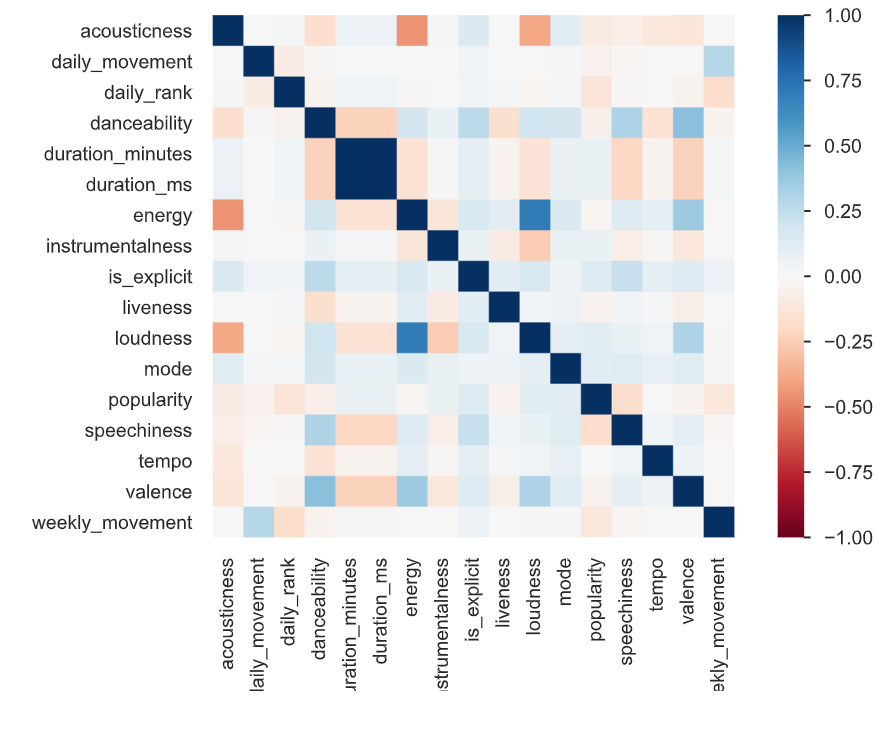

Okay! Some interesing things we can see from the report:
- Most popular songs are *not* explicit! I'd wager this is because a clean song can be played in more places, like office parties and school dances.
- The average song length is 3 minutes and 14.20 seconds
- Based on the heatmap: energy and loudness is highly positively corrleated (makes sense), and popularity is seemingly negatively correlated with almost all the factors but it's increadibly low
- There seems to be little to no correlation between the features of a song and it's daily and weekly movement, so maybe songs move because bigger songs drop or just because people got tired of it

In [ ]:
#I had some issues with the outputs in JPYNB so this helps show the outputs
import plotly.offline as pyo

# Set notebook mode to work in offline
pyo.init_notebook_mode()

##### Are songs getting shorter?

Ever since TikTok (and formerly, Musically) came around everyone says pop music has gotten shorter. I came across [this](https://www.reddit.com/r/dataisbeautiful/comments/uh682b/oc_song_length_and_tempo_of_popular_music_from/i740ogi/) chart that shows that the duration has actually been declining since the 1990s (likely because we're not doing 20 minute drum solos anymore). While this set isn't as historic as I'd like it to be, I still found it interesting to see a monthly view of our Spotify dataset! 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

spotify['year_month'] = spotify['snapshot_date'].dt.to_period('M')  # since we want to plot it monthly, this will create a column with just the year and month
monthly_avg = spotify.groupby('year_month')['duration_minutes'].mean()   # group by year_month and calculate the average duration in minutes
monthly_avg.plot(kind='line', marker='o')     # a simple line plot because we just want to see the treand over time
plt.title('Average Song Duration (Monthly)')
plt.xlabel('Month')
plt.ylabel('Average Duration (minutes)')

plt.show()

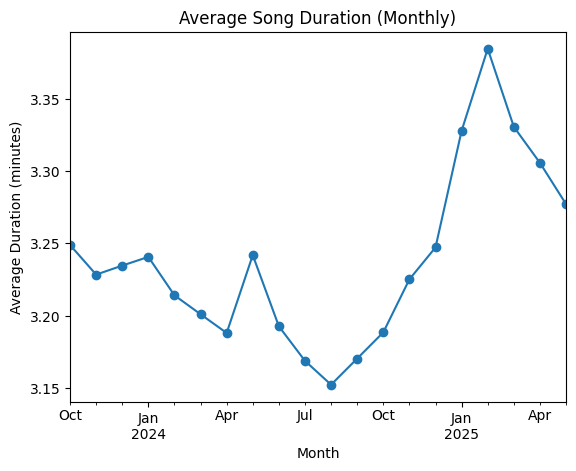

Well, the average song duration has been stable between 3.38 minutes and 3.1 minutes for our time period!

##### Which countries think swearing is cool? A map of how popular explicit songs are in each country

In [ ]:
#let's use standardised ISO-3 country code system before we use plotly
import pycountry

def convert_country_code(alpha2_code):
    try:
        country = pycountry.countries.get(alpha_2=alpha2_code)
        return country.alpha_3 if country else alpha2_code
    except:
        return alpha2_code

spotify['country'] = spotify['country'].apply(convert_country_code)

# and now the plot
import plotly.express as pxb

px.choropleth(spotify.groupby('country').mean().reset_index(), locations='country', locationmode='ISO-3', color_continuous_scale="spectral", color='is_explicit', title='Popularity of Explicit Songs in Each Country').show()

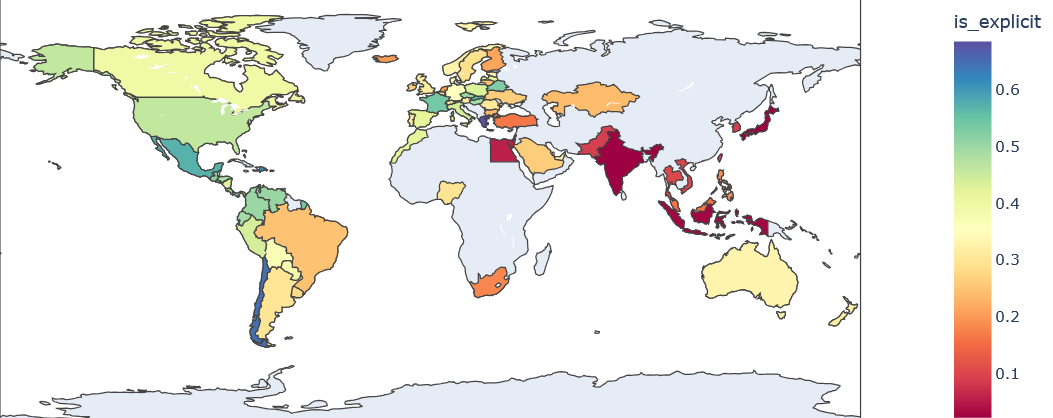

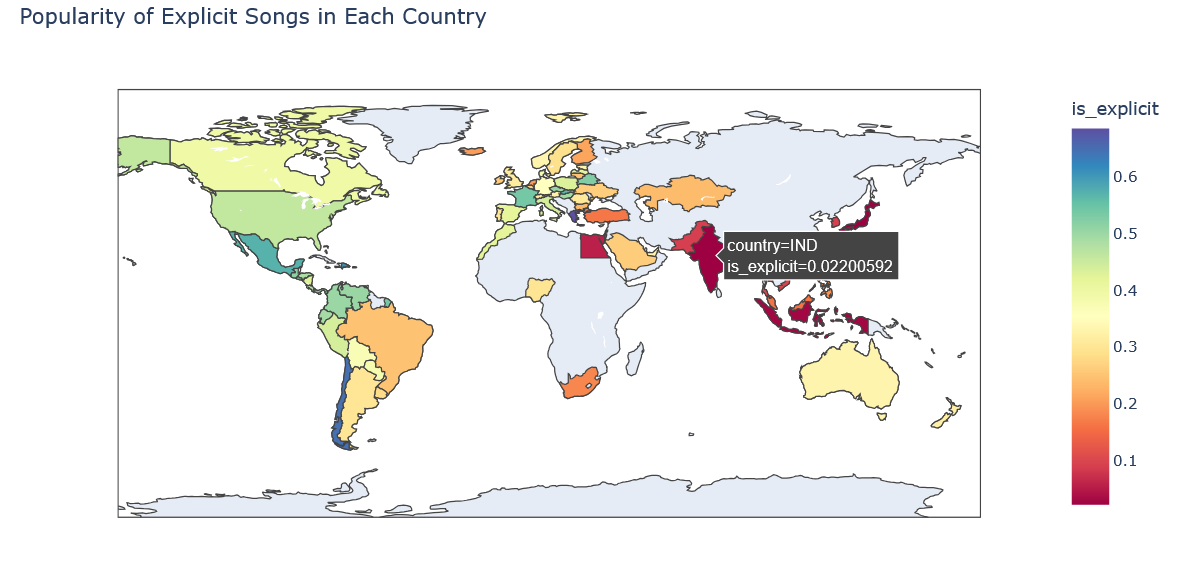

The scale on the side  is the average level of profanity in the top songs. The closer it is to 1, more songs in the top 50 are, on average, explicit.

So, we see that India, Indonesia, Japan, and Egypt are countries where songs with little to no profanity are most popular. Mexico, Chile, Greece and the Dominican Republic are huge fans of explicit songs. Actually, I found that [Mexico likes swearing!](https://www.mentalfloss.com/posts/countries-that-swear-the-most-mapped)

##### Guitars Anyone? A map of how popular acoustic songs are in each country

In [ ]:
import plotly.express as px

px.choropleth(spotify.groupby('country').mean().reset_index(), locations='country', locationmode='ISO-3', color='acousticness', color_continuous_scale="sunset", title='Global Popularity of Acoustic Music').show()

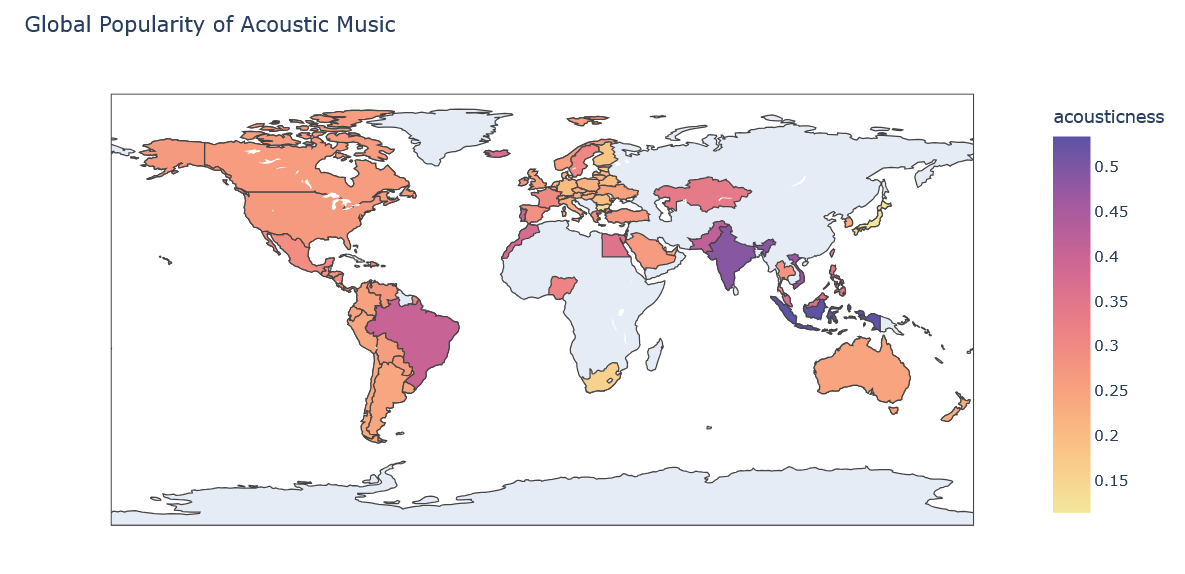

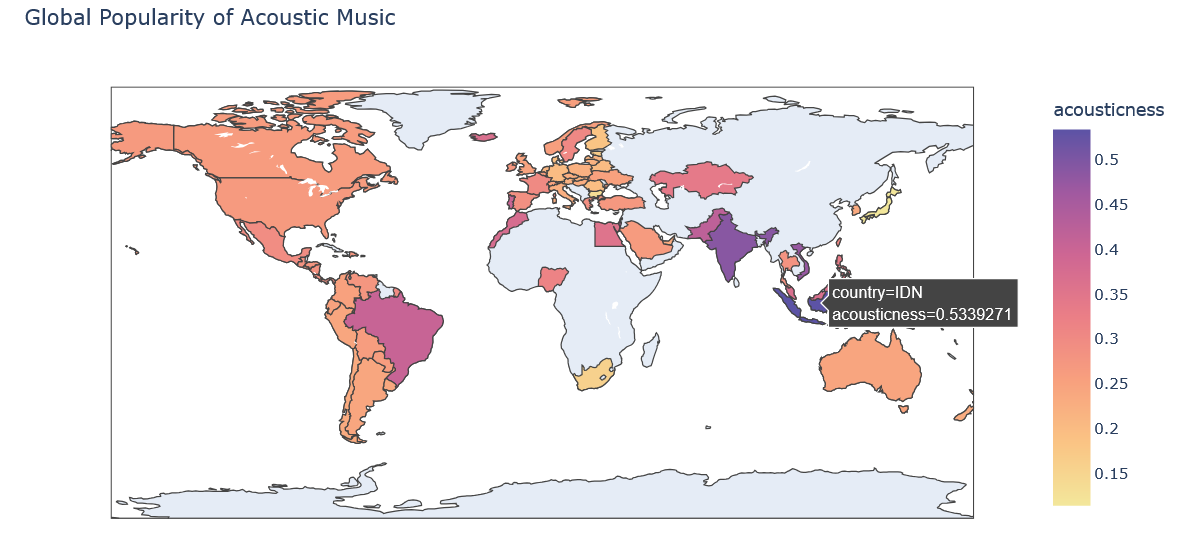

Indonesia loves acoustic music the most! This sounds right to me, growing up the radio was always playing acoustic songs. Vietnam, India, Pakistan and Brazil are the markets that like adore acoustic music. South Africa, Japan, and Bulgaria are countries that like acoustic songs the least.

##### The Key to Popularity: are songs in a major key more popular than songs in a minor key?

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

spotify.groupby('mode')['popularity'].mean().plot(kind='bar', color=['purple', 'skyblue']) # group by average popularity of key and plot a box plot 
plt.title("Major or Minor?")
plt.xlabel("Key")
plt.xticks([0, 1], ['Minor', 'Major'])
plt.ylabel("Average Popularity")
plt.show()

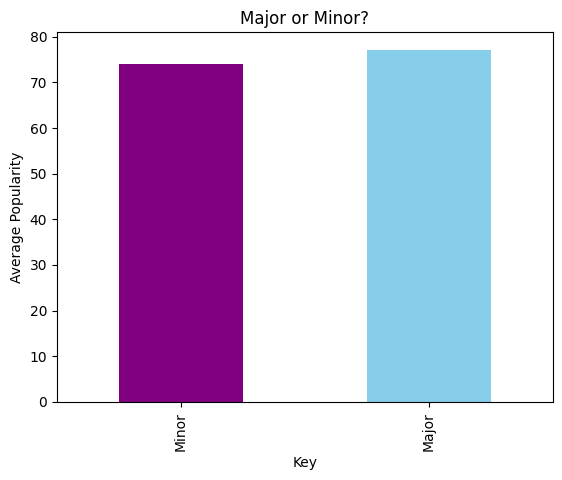

Although songs are pretty evenly distributed, it seems songs in a major key are more popular

##### Turn it up! Are louder songs more popular?

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(spotify['loudness'], bins=40, kde=True)
plt.title('Distribution of Loudness Overall')
plt.show()

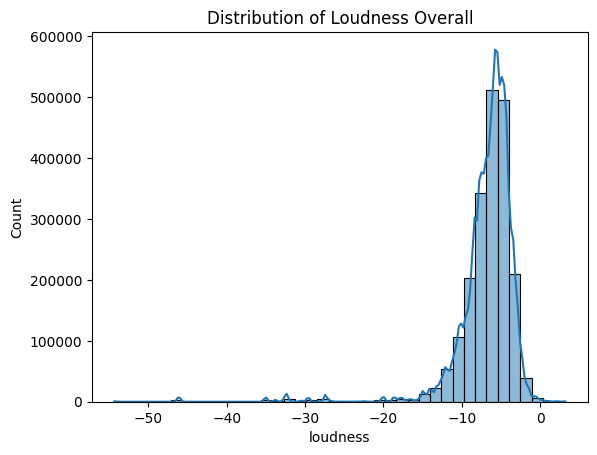

Most top-charting songs are loud, as we see the data is left skewed. Actually, it seems music is pretty standarised with a few outliers towards the -30 decibles and lower end.

##### Amped Up: a look at the relation between Valence and Tempo.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

joint_plt = sns.jointplot(data=spotify, x='tempo', y='valence', kind='scatter', marginal_kws=dict(bins=50, fill=True), s=10)
joint_plt.fig.suptitle("How Tempo and Valence are Related", y=1.02)
joint_plt.set_axis_labels("Tempo", "Valence")
plt.show()

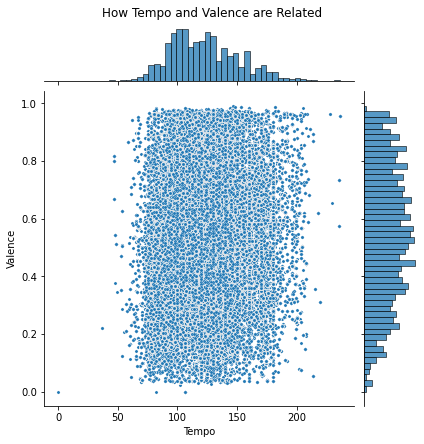

Here, I was expecting to see a positive trend. I thought songs that had a positive message would be more upbeat. But, since there is no clear correlation between the Valence (measure of positivity) and Tempo, it seems artists aren’t relying on tempo to express emotional tone. We also see a pretty wide spread for the histogram plotting positivity as a factor of top 50 songs, meaning the songs are very diverse in terms of valence -- depressing songs are just as popular as happy ones.

##### A timeseries analysis of how danceability and valence have trended in the UK over the last few years

In [ ]:
import plotly.express as px

# Your existing data preparation code
time_series = spotify.groupby(['snapshot_date', 'country']).agg({
    'danceability': 'mean',
    'valence': 'mean'
})
ts = time_series.xs('GBR', level='country').reset_index()

# Reset index to make it work with px
ts_melted = ts.melt(id_vars=['snapshot_date'], 
                         value_vars=['danceability', 'valence'],
                         var_name='metric', value_name='value')

fig2 = px.line(ts_melted, 
               x='snapshot_date', 
               y='value', 
               color='metric',
               color_discrete_map={'danceability': '#00968b', 'valence': '#660066'},
               title='Danceability and Valence over Time in the UK',
               labels={'snapshot_date': 'Snapshot Date', 'value': 'Value'})

fig2.update_traces(mode='lines+markers', marker=dict(size=6))
fig2.update_layout(width=1000, height=600)
fig2.show()

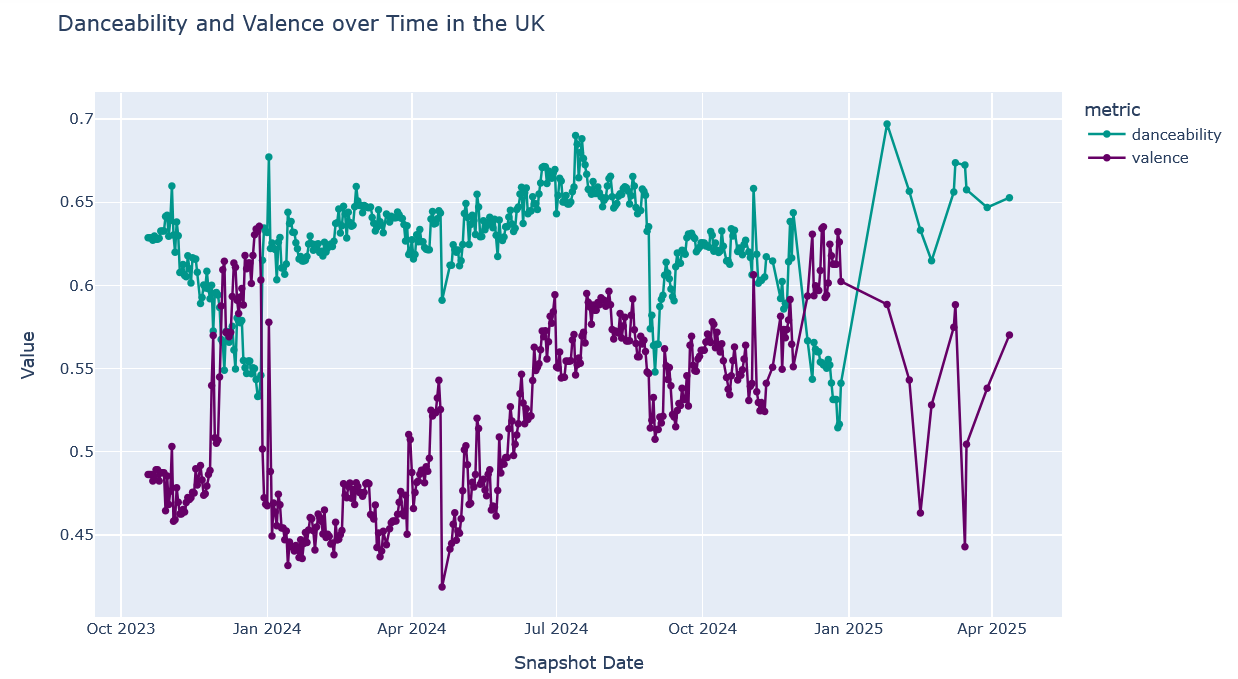

Here, I was eager to explore if Charli xcx's *Brat* had any ifluence on music trends. I've heard that the club scene was on the decline in the UK due to inflation and economic downturn. *Brat* was a hyperpop club music album and it was everywhere. If it influenced people's tastes and music we'd expect a huge jump any point around June 7-June 14th (the album dropped June 7). But we don't see anything that suggests this. I'm not sure what happened in January 2025, but it seems to be an inflection point where danceability skyrocketed and around the time positive music declined.